## Dynamic Delta Hedging Framework

#### Introduction

Dynamic delta hedging is a complex process influenced by stochastic factors such as noise (volatility) and drift (trend) in asset price movements. This framework aims to optimize delta hedging by targeting the Sharpe Ratio, balancing between P&L variance and option book returns.

#### Assumptions

##### Asset Price Dynamics:

Financial assets (currencies, interest rates, equities, etc.) follow a stochastic process characterized by:
Noise (Volatility)
Drift (Trend)

##### Regime Characterization:

We simplify the asset dynamics by assuming two regimes for each factor (Volatility and Drift):
Low Volatility / High Volatility
Low Drift / High Drift
This results in a 2x2 matrix of possible states.

### Regime Determination

To identify the current regime, we apply decision rules based on volatility and trend.

##### 1. Volatility Regime
Objective: Determine whether we are in a high or low volatility state.
Method: Compare realized short-dated volatility (1-2 days) to longer-term historical volatility (1 month).
Decision Rule:
High Volatility: If 2-day realized volatility > (1-month volatility + threshold * standard deviation)
Low Volatility: Otherwise
Note: The threshold is a key parameter affecting signal sensitivity.

#### 2. Trend Regime
Objective: Measure the persistence of the trend (mean-reversion vs. trend-following).
Method: Use the Variance Ratio (VR), comparing high-frequency realized variance to close-close realized variance.

#### Decision Rule:
High Trend: If VR < threshold (implies trend-following behavior)
Mean-Reversion: Otherwise

#### Note: Selection of the VR threshold is crucial for determining the trend regime.

### Hedging Strategies

Based on the identified regimes, the following hedging strategies can be applied:

#### 1. Hedging as a Function of Time
Description: Hedge at regular time intervals, independent of underlying asset dynamics.
Use Case: Simple strategy often used in practice, but it does not account for intraday dynamics.
#### 2. Hedging as a Function of % Change in the Underlying Asset
Description: Hedge based on the percentage movement of the underlying asset.
Use Case: More dynamic, but the $delta can vary significantly based on the gamma profile and proximity to strike price.
#### 3. Hedging as a Function of Accumulated Delta
Description: Hedge based on the accumulated delta since the last hedge.
Use Case: This strategy adjusts hedging frequency based on the gamma/delta profile, hedging more frequently near strikes and closer to expiration.

### Hedging Scheme Implementation

Based on the identified volatility and trend regimes, select the appropriate hedging strategy:

#### a. Low Volatility / Low Drift
Strategy: Hedge frequently using delta or % change-based strategies, depending on the proximity to strike and gamma profile.

#### b. Low Volatility / High Drift
Strategy: Hedge less frequently to capture the trend. Consider a time-based or % change strategy with a sufficient threshold.

#### c. High Volatility / Low Drift
Strategy: Hedge frequently using delta-based strategy with a higher volatility assumption.

#### d. High Volatility / High Drift
Strategy: Hedge less frequently, allowing the delta to run while setting a high volatility parameter.

#### Step 1: Importing Libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Step 2: Data Preparation

In [9]:
# Fetch data (repeating from previous steps)
yf.pdr_override()
start_date = '2023-01-01'
end_date = '2024-01-01'


data = pdr.get_data_yahoo('SPY', start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


#### Calculate returns and volatilities

In [10]:
# Calculate returns and volatilities 
data['Returns'] = data['Adj Close'].pct_change()
data['1M_Vol'] = data['Returns'].rolling(window=21).std() * np.sqrt(252)
data['2D_Vol'] = data['Returns'].rolling(window=2).std() * np.sqrt(252)
data['Intraday_Vol'] = np.log(data['High'] / data['Low']).rolling(window=21).std() * np.sqrt(252)

#### Step 3: Regime Classification and hedging strategy implementation

In [11]:
# Regime Classification (repeating from previous steps)
vol_threshold = 1.5
drift_threshold = 1.2
data['Vol_Regime'] = np.where(data['2D_Vol'] > data['1M_Vol'] * vol_threshold, 'High Vol', 'Low Vol')
data['Variance_Ratio'] = data['Intraday_Vol'] / data['1M_Vol']
data['Trend_Regime'] = np.where(data['Variance_Ratio'] < drift_threshold, 'High Trend', 'Low Trend')

In [14]:
# Initialize P&L tracking variables
data['PnL'] = 0.0
data['Cumulative_PnL'] = 0.0
data['Hedge_Action'] = False

last_hedge_price = data['Adj Close'][0]
accumulated_delta = 0
threshold_delta = 0.05

for i in range(1, len(data)):
    current_price = data['Adj Close'][i]
    previous_price = data['Adj Close'][i-1]
    current_vol_regime = data['Vol_Regime'][i]
    current_trend_regime = data['Trend_Regime'][i]

    # Hedging strategy based on regime
    if current_vol_regime == 'Low Vol' and current_trend_regime == 'Low Trend':
        decision = 'Time-Based Hedging'
        # For simplicity, let's say we hedge daily for this strategy
        hedge_price = current_price
    elif current_vol_regime == 'Low Vol' and current_trend_regime == 'High Trend':
        decision = 'Percent Change-Based Hedging'
        if abs(current_price - last_hedge_price) / last_hedge_price > 0.01:
            hedge_price = current_price
        else:
            hedge_price = None
    elif current_vol_regime == 'High Vol' and current_trend_regime == 'Low Trend':
        decision = 'Accumulated Delta-Based Hedging'
        accumulated_delta += np.random.randn() * 0.01  # Example delta adjustment
        if abs(accumulated_delta) > threshold_delta:
            hedge_price = current_price
            accumulated_delta = 0  # Reset after hedging
        else:
            hedge_price = None
    else:
        decision = 'Custom Hedging for High Vol / High Trend'
        hedge_price = None

    # If a hedging action is taken, calculate the P&L
    if hedge_price is not None:
        data.at[data.index[i], 'Hedge_Action'] = True
        # Calculate P&L: (Last hedge price - current price) * hedged quantity
        pnl = (hedge_price - previous_price) * 1  # Assuming 1 unit hedged for simplicity
        data.at[data.index[i], 'PnL'] = pnl
        last_hedge_price = hedge_price
    else:
        data.at[data.index[i], 'PnL'] = 0.0

    # Cumulative P&L
    data.at[data.index[i], 'Cumulative_PnL'] = data['Cumulative_PnL'][i-1] + data['PnL'][i]

#### Perfromance Review

Sharpe Ratio: 1.9558568242521817


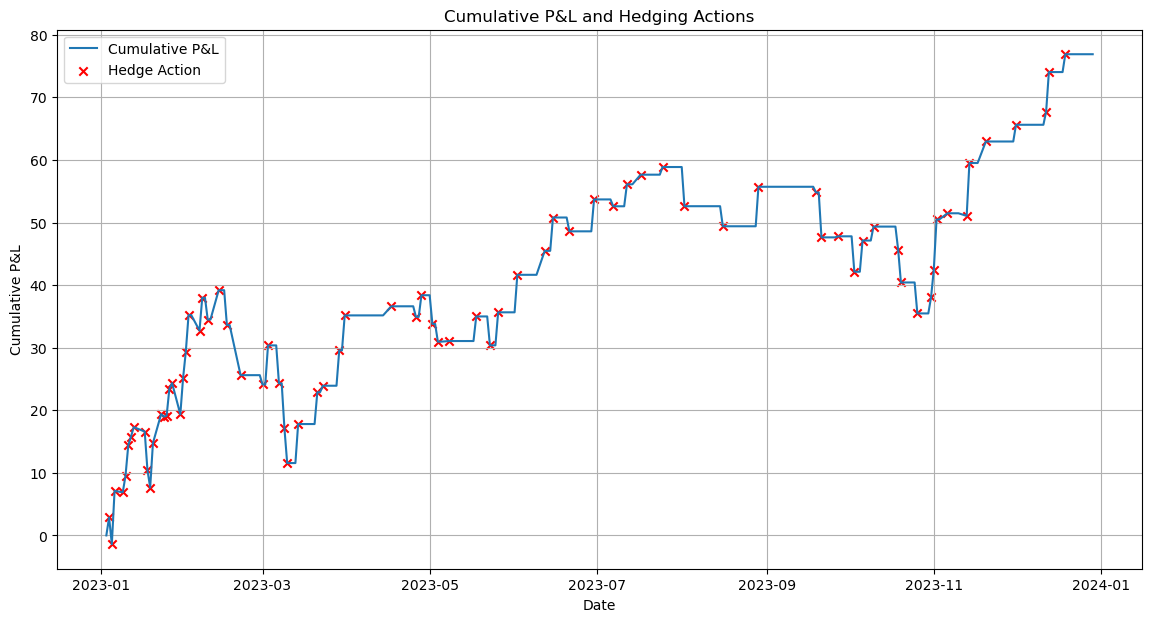

In [15]:
# Calculate Sharpe Ratio
average_daily_return = data['PnL'].mean()
std_daily_return = data['PnL'].std()
sharpe_ratio = average_daily_return / std_daily_return * np.sqrt(252)
print(f"Sharpe Ratio: {sharpe_ratio}")

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Cumulative_PnL'], label='Cumulative P&L')
plt.scatter(data.index[data['Hedge_Action']], data['Cumulative_PnL'][data['Hedge_Action']], color='red', label='Hedge Action', marker='x')
plt.title('Cumulative P&L and Hedging Actions')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L')
plt.legend()
plt.grid(True)
plt.show()